In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import keras.backend as K #to define custom loss function

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from pprint import pprint
from collections import defaultdict
import openslide
from openslide import OpenSlide

from glob import glob

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.layers import GlobalMaxPooling2D
from keras.models import load_model

print(keras.__version__)

2.6.0


In [2]:
#train_df = pd.read_csv('../input/mayo-clinic-strip-ai/train.csv')
#test_df  = pd.read_csv('../input/mayo-clinic-strip-ai/test.csv')
#train_df.head()

# Specify patient_ids to remove
#patient_ids_to_remove = ['006388', '008e5c', '00c058', '01adc5']

# Filter out the rows with specified patient_ids
#train_df = train_df[~train_df['patient_id'].isin(patient_ids_to_remove)].reset_index(drop=True)

# Print the cleaned DataFrame
#print("Cleaned DataFrame:")
#print(train_df.head())

import random

train_df = pd.read_csv('../input/mayo-clinic-strip-ai/train.csv')
test_df  = pd.read_csv('../input/mayo-clinic-strip-ai/test.csv')

# Specify patient_ids to remove
#patient_ids_to_remove = ['006388', '008e5c', '00c058', '01adc5']

# Filter out the rows with specified patient_ids
#train_df = train_df[~train_df['patient_id'].isin(patient_ids_to_remove)].reset_index(drop=True)
#train_df = train_df.drop_duplicates(subset=['patient_id'])

df1 = train_df[train_df['label'] == 'CE']
df2 = train_df[train_df['label'] == 'LAA']
#adjust n to change number of CE data
sampled= df1.sample(n=200, random_state=42)
train_df = pd.concat([sampled, df2],ignore_index=True)
# Print the cleaned DataFrame
print("Cleaned DataFrame:")
print(train_df.head())
train_df['label'].value_counts()

Cleaned DataFrame:
   image_id  center_id patient_id  image_num label
0  4f6fb1_1         10     4f6fb1          1    CE
1  217b27_0         11     217b27          0    CE
2  a4e918_0         11     a4e918          0    CE
3  2745fc_0         11     2745fc          0    CE
4  aa2f56_0          9     aa2f56          0    CE


LAA    207
CE     200
Name: label, dtype: int64

## Data viusalization

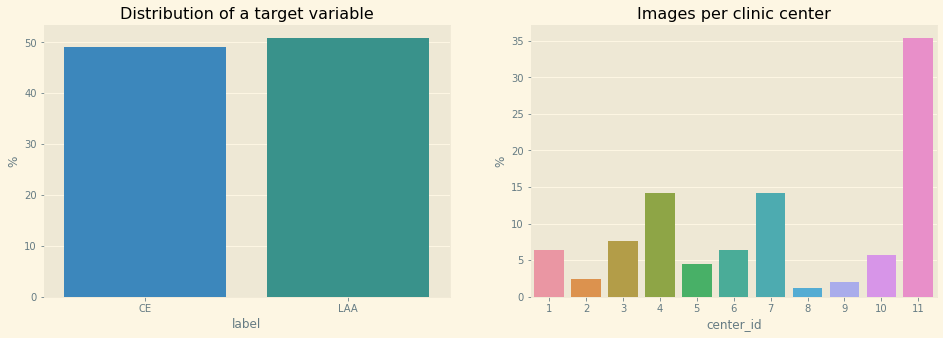

Train Size = 407
Test Size = 4


In [3]:
##### CLASS DISTRIBUTION

plt.style.use('Solarize_Light2')
labels = train_df.groupby('label')['label'].count().div(len(train_df)).mul(100)
centers = train_df.groupby("center_id")['center_id'].count().div(len(train_df)).mul(100)

fig, ax = plt.subplots(1,2, figsize=(16,5))
sns.barplot(x=labels.index, y=labels.values, ax=ax[0])
ax[0].set_title("Distribution of a target variable"), ax[0].set_ylabel("%")
sns.barplot(x=centers.index, y=centers.values, ax=ax[1])
ax[1].set_title("Images per clinic center"), ax[1].set_ylabel("%")
plt.show()

print('Train Size = {}'.format(len(train_df)))
print('Test Size = {}'.format(len(test_df)))



## From this plot we notice that there is a class imbalance which we will deal with later in this notebook

In [4]:
train_images = glob("/kaggle/input/mayo-clinic-strip-ai/train/*")
test_images = glob("/kaggle/input/mayo-clinic-strip-ai/test/*")
other_images = glob("/kaggle/input/mayo-clinic-strip-ai/other/*")
print(f"Number of images in a training set: {len(train_images)}")
print(f"Number of images in a training set: {len(test_images)}")
print(f"Number of other: {len(other_images)}")

# Filtering out images based on the cleaned patient_ids in train_df
images_to_remove = [
    '/kaggle/input/mayo-clinic-strip-ai/train/006388_0.tif',
    '/kaggle/input/mayo-clinic-strip-ai/train/008e5c_0.tif',
    '/kaggle/input/mayo-clinic-strip-ai/train/00c058_0.tif',
    '/kaggle/input/mayo-clinic-strip-ai/train/01adc5_0.tif',
]

# Remove images associated with the patient_ids
train_images = [img for img in train_images if img not in images_to_remove]

# Check the total number of images after deletion
total_images_after_deletion = len(train_images)
print("Total number of images after deletion:", total_images_after_deletion)

# Print the paths of the cleaned list of images
print("First 5 image paths after deletion:")
print(train_images[:5])

Number of images in a training set: 754
Number of images in a training set: 4
Number of other: 396
Total number of images after deletion: 750
First 5 image paths after deletion:
['/kaggle/input/mayo-clinic-strip-ai/train/a4c7df_0.tif', '/kaggle/input/mayo-clinic-strip-ai/train/f9fc6b_0.tif', '/kaggle/input/mayo-clinic-strip-ai/train/0d718a_0.tif', '/kaggle/input/mayo-clinic-strip-ai/train/86e319_1.tif', '/kaggle/input/mayo-clinic-strip-ai/train/54838a_0.tif']


In [5]:
img_prop = defaultdict(list)

for i, path in enumerate(train_images):
    img_path = train_images[i]
    slide = OpenSlide(img_path)    
    img_prop['image_id'].append(img_path[-12:-4])
    img_prop['width'].append(slide.dimensions[0])
    img_prop['height'].append(slide.dimensions[1])
    img_prop['size'].append(round(os.path.getsize(img_path) / 1e6, 2))
    img_prop['path'].append(img_path)

image_data = pd.DataFrame(img_prop)
image_data['img_aspect_ratio'] = image_data['width']/image_data['height']
image_data.sort_values(by='image_id', inplace=True)
image_data.reset_index(inplace=True, drop=True)

image_data = image_data.merge(train_df, on='image_id')
image_data.head()

,image_id,width,height,size,path,img_aspect_ratio,center_id,patient_id,image_num,label
0,026c97_0,10533,8267,61.21,/kaggle/input/mayo-clinic-strip-ai/train/026c9...,1.274102,4,026c97,0,CE
1,028989_0,32789,85695,1721.26,/kaggle/input/mayo-clinic-strip-ai/train/02898...,0.382624,5,028989,0,LAA
2,0372b0_0,4841,25138,45.77,/kaggle/input/mayo-clinic-strip-ai/train/0372b...,0.192577,7,0372b0,0,CE
3,037300_0,27346,70968,604.65,/kaggle/input/mayo-clinic-strip-ai/train/03730...,0.385329,11,037300,0,CE
4,03d1ec_0,23125,30421,237.11,/kaggle/input/mayo-clinic-strip-ai/train/03d1e...,0.760166,11,03d1ec,0,LAA


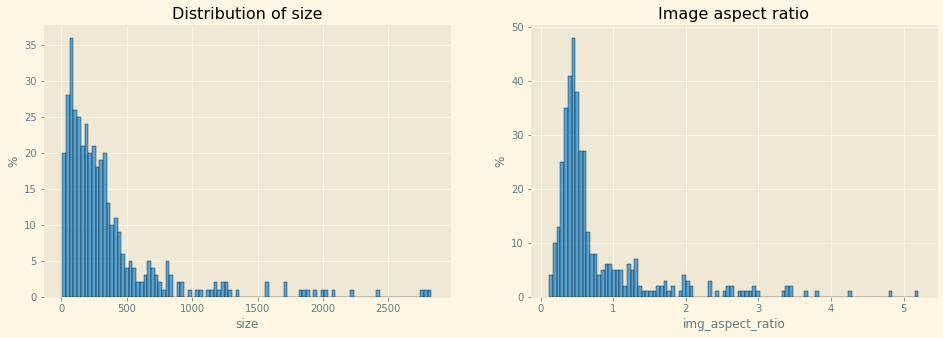

In [6]:
plt.style.use('Solarize_Light2')

fig, ax = plt.subplots(1,2, figsize=(16,5))
sns.histplot(x='size', data = image_data, bins=100, ax=ax[0])
ax[0].set_title("Distribution of size"), ax[0].set_ylabel("%")
sns.histplot(x='img_aspect_ratio', data = image_data, bins=100, ax=ax[1])
ax[1].set_title("Image aspect ratio"), ax[1].set_ylabel("%")
plt.show()

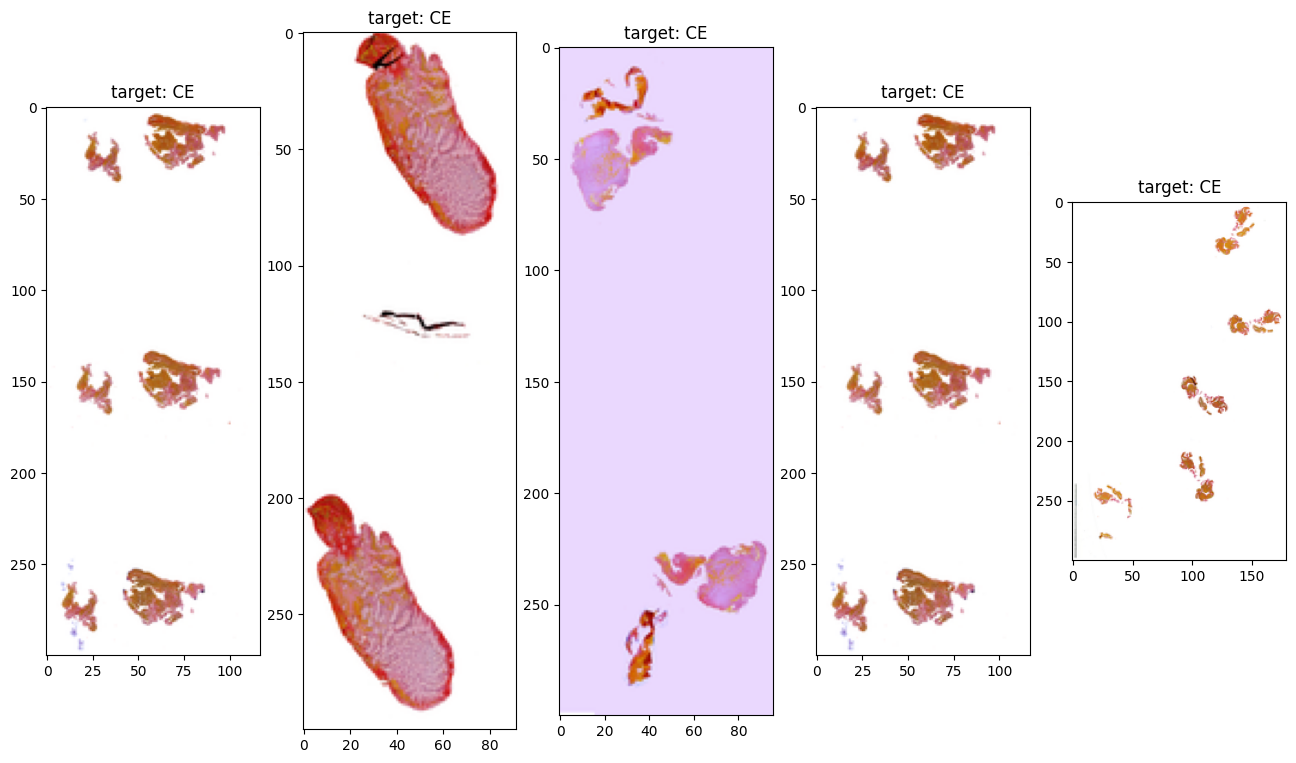

In [7]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None 

CE_imgs = image_data.loc[image_data['label']=='CE','path']
LAA_imgs = image_data.loc[image_data['label']=='LAA','path']


plt.style.use('default')
fig, axes = plt.subplots(1,5, figsize=(16,16))
train_images
for ax in axes.reshape(-1):
    img_path = np.random.choice(CE_imgs)
    img = Image.open(img_path)   
    img.thumbnail((300,300), Image.Resampling.LANCZOS)
    ax.imshow(img), ax.set_title("target: CE")
plt.show()

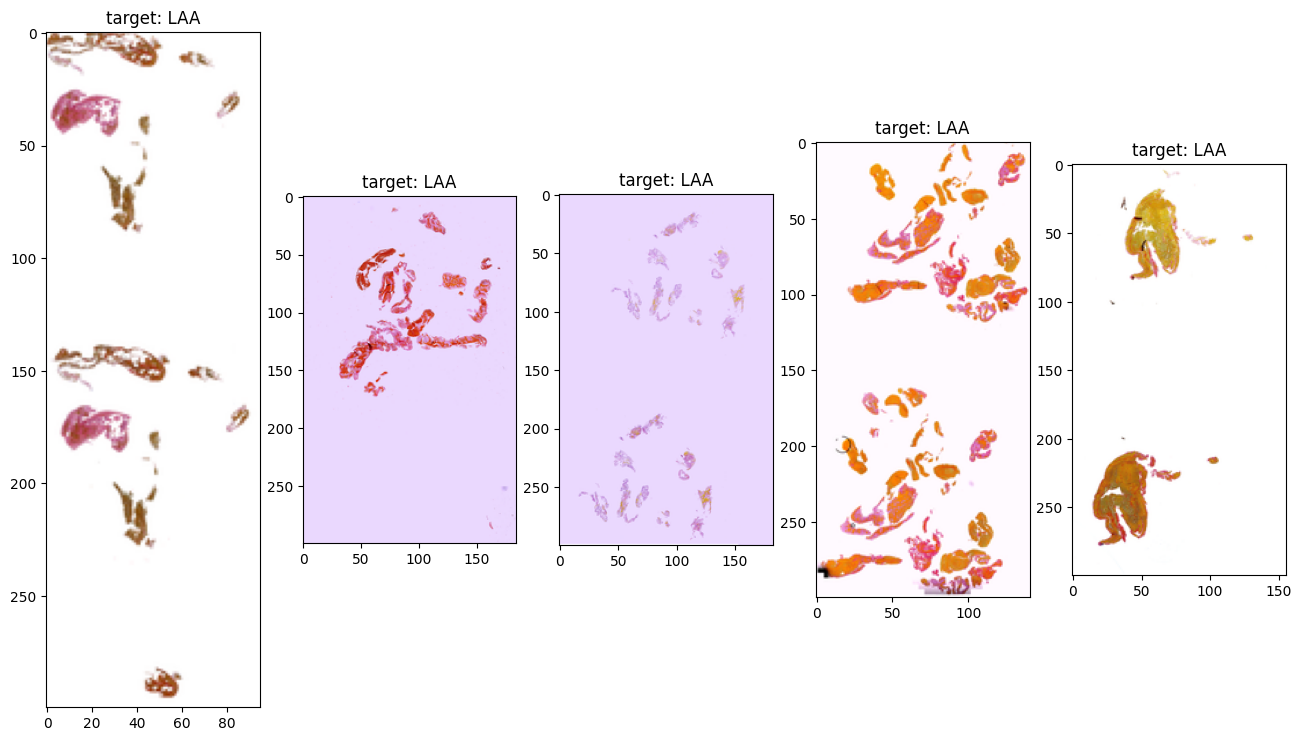

In [8]:
fig, axes = plt.subplots(1,5, figsize=(16,16))
train_images
for ax in axes.reshape(-1):
    img_path = np.random.choice(LAA_imgs)
    img = Image.open(img_path)   
    img.thumbnail((300,300), Image.Resampling.LANCZOS)
    ax.imshow(img), ax.set_title("target: LAA")
plt.show()

## First impressions:

- Images sizes are from small ones to a high-resolution ones
- Images have different aspect ratios
- Backgrounds have different colours
- Clots are usually in the form of multiple small pieces
- Blood clots have different colours

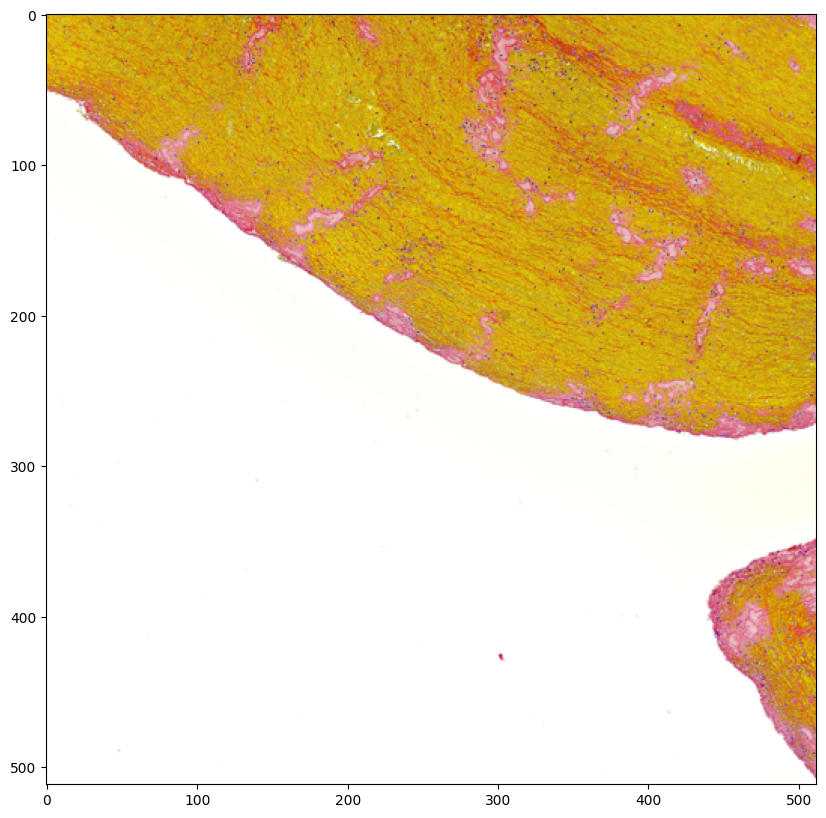

In [9]:
slide = OpenSlide('/kaggle/input/mayo-clinic-strip-ai/train/026c97_0.tif') # opening a full slide

region = (2500, 2000) # location of the top left pixel
level = 0 # level of the picture (we have only 0)
size = (3500, 3500) # region size in pixels

region = slide.read_region(region, level, size)
image = region.resize((512, 512))
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()


![image](https://upload.wikimedia.org/wikipedia/commons/0/06/Composition_of_a_fresh_thrombus.jpg)

## Approach 1

## Loading Data

In [10]:
train_df["file_path"] = train_df["image_id"].apply(lambda x: "../input/mayo-clinic-strip-ai/train/" + x + ".tif")
test_df["file_path"]  = test_df["image_id"].apply(lambda x: "../input/mayo-clinic-strip-ai/test/" + x + ".tif")

In [11]:
# labelling CE class as 1 and LAA as 0
train_df["target"] = train_df["label"].apply(lambda x : 1 if x=="CE" else 0)
train_df.head()

,image_id,center_id,patient_id,image_num,label,file_path,target
0,4f6fb1_1,10,4f6fb1,1,CE,../input/mayo-clinic-strip-ai/train/4f6fb1_1.tif,1
1,217b27_0,11,217b27,0,CE,../input/mayo-clinic-strip-ai/train/217b27_0.tif,1
2,a4e918_0,11,a4e918,0,CE,../input/mayo-clinic-strip-ai/train/a4e918_0.tif,1
3,2745fc_0,11,2745fc,0,CE,../input/mayo-clinic-strip-ai/train/2745fc_0.tif,1
4,aa2f56_0,9,aa2f56,0,CE,../input/mayo-clinic-strip-ai/train/aa2f56_0.tif,1


## Preprocessing

In [12]:
%%time
def preprocess(image_path):
    slide=OpenSlide(image_path)
    region= (2500,2500)    
    size  = (5000, 5000)
    image = slide.read_region(region, 0, size)
    image = image.resize((128, 128))
    image = np.array(image)    
    return image

X_train=[]
for i in tqdm(train_df['file_path']):
    x1=preprocess(i)
    X_train.append(x1)

Y_train=[]    
Y_train=train_df['target']

100%|██████████| 407/407 [29:14<00:00,  4.31s/it]

CPU times: user 8min 33s, sys: 2min 4s, total: 10min 37s
Wall time: 29min 14s


In [13]:
X_train=np.array(X_train)
X_train=X_train/255.0
Y_train = np.array(Y_train)

In [14]:
## Splitting data
x_train,x_test,y_train,y_test=train_test_split(X_train,Y_train, test_size=0.3, random_state=42)
# ## Splitting data
x_train,x_val,y_train,y_val=train_test_split(X_train,Y_train, test_size=0.5, random_state=42)

In [15]:
print(x_train.shape)

(203, 128, 128, 4)


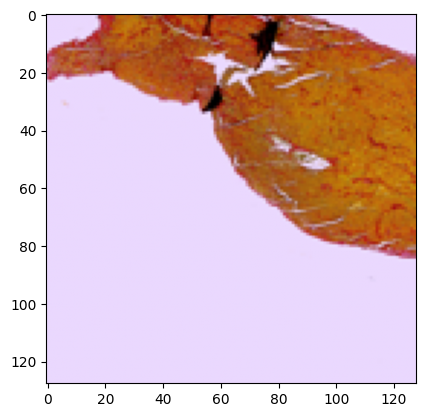

In [16]:
plt.imshow(x_train[0])

## Our CNN approach

In [17]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [18]:
#Revised Version
#from keras import metrics
#from keras.layers import Dense

#model = Sequential()
#input_shape = (128, 128, 4)

#model.add(Conv2D(filters=64, kernel_size = (5,5), padding = 'valid', activation = 'relu', input_shape = input_shape))
#model.add(MaxPooling2D())
#model.add(Conv2D(filters=64, kernel_size = (5,5), strides =1, padding = 'valid', activation = 'relu'))
#model.add(Conv2D(filters=64, kernel_size = (5,5), strides =1, padding = 'valid', activation = 'relu'))
#model.add(Conv2D(filters=64, kernel_size = (5,5), strides =1, padding = 'valid', activation = 'relu'))
#model.add(Conv2D(filters=128, kernel_size = (5,5), strides =1, padding = 'valid', activation = 'relu'))
#model.add(Conv2D(filters=128, kernel_size = (5,5), strides =1, padding = 'valid', activation = 'relu'))

#model.add(Dropout(0.13))
#model.add(Flatten())
#model.add(Dense(256, activation = 'relu'))
#model.add(Dropout(0.13))
#model.add(Dense(100, activation = 'relu'))
#model.add(Dense(50, activation = 'relu'))
#model.add(Dense(1 , activation="sigmoid"))

#model.compile(
   #loss = tf.keras.losses.BinaryCrossentropy(),
   # metrics=[metrics.binary_accuracy,f1_score],
    #optimizer = tf.keras.optimizers.Adam(1e-3))

#model.summary()

from keras import metrics
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
model = Sequential()
input_shape = (128, 128, 4)

model.add(Conv2D(filters=128, kernel_size = (1,1), padding = 'valid', activation = 'relu', input_shape = input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(filters=64, kernel_size = (1,1), strides =2, padding = 'valid', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(filters=32, kernel_size = (1,1), strides =2, padding = 'valid', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(filters=16, kernel_size = (1,1), strides =2, padding = 'valid', activation = 'relu'))
model.add(BatchNormalization())


# model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Flatten())

model.add(Dense(512, activation='relu')) 
model.add(Dropout(0.13))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.13))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.13))
model.add(Dense(1, activation="sigmoid"))

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics=[metrics.binary_accuracy,f1_score],
    optimizer = tf.keras.optimizers.Adam(1e-6))

dot_img_file = 'model.png'
# tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [19]:
from sklearn.utils import compute_class_weight
train_classes = Y_train
class_weights = compute_class_weight(class_weight = "balanced",
                                        classes = np.unique(train_classes),
                                        y = train_classes                                                    
                                    )
class_weights = dict(zip(np.unique(train_classes), class_weights))
print(class_weights)

{0: 0.9830917874396136, 1: 1.0175}


## This is where we balance class weights

In [20]:
from sklearn.utils import compute_class_weight
train_classes = Y_train
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_classes),
                                        y = train_classes                                                    
                                    )
class_weights = dict(zip(np.unique(train_classes), class_weights))
class_weights

{0: 0.9830917874396136, 1: 1.0175}

## Training the model

In [21]:
#callback = tf.keras.callbacks.ModelCheckpoint(
#    filepath='our_cnn_best.h5',
 #   monitor='val_binary_accuracy',
 #   mode='max',
 #   save_best_only=True, verbose=1)
#model.fit(
#    x_train,
#    y_train,
#    epochs = 10,
 #   batch_size=20,
 #   validation_data = (x_test,y_test),
 #   class_weight= class_weights,
 #   callbacks = callback
#)

In [22]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

# Fit the model
model.fit(
    x_train,
    y_train,
    epochs=100,  # Increased epochs
    batch_size=32,
    validation_data=(x_val, y_val),
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1 
)

Epoch 1/100
7/7 [==============================] - 8s 100ms/step - loss: 0.6977 - binary_accuracy: 0.5419 - f1_score: 0.2821 - val_loss: 0.6936 - val_binary_accuracy: 0.4657 - val_f1_score: 0.0000e+00
Epoch 2/100
7/7 [==============================] - 0s 33ms/step - loss: 0.6960 - binary_accuracy: 0.5419 - f1_score: 0.2199 - val_loss: 0.6942 - val_binary_accuracy: 0.4657 - val_f1_score: 0.0000e+00
Epoch 3/100
7/7 [==============================] - 0s 34ms/step - loss: 0.6860 - binary_accuracy: 0.5419 - f1_score: 0.2866 - val_loss: 0.6943 - val_binary_accuracy: 0.4657 - val_f1_score: 0.0000e+00
Epoch 4/100
7/7 [==============================] - 0s 33ms/step - loss: 0.7120 - binary_accuracy: 0.5320 - f1_score: 0.2453 - val_loss: 0.6944 - val_binary_accuracy: 0.4657 - val_f1_score: 0.0000e+00
Epoch 5/100
7/7 [==============================] - 0s 32ms/step - loss: 0.6891 - binary_accuracy: 0.5517 - f1_score: 0.3465 - val_loss: 0.6943 - val_binary_accuracy: 0.4657 - val_f1_score: 0.0000e+00

In [23]:
best_cnn = load_model('/kaggle/working/best_model.h5', custom_objects={"f1_score": f1_score })
best_cnn.evaluate(x_test,y_test)

4/4 [==============================] - 0s 15ms/step - loss: 0.6935 - binary_accuracy: 0.4715 - f1_score: 0.0000e+00


[0.6934853196144104, 0.47154471278190613, 0.0]

Text(0.5, 25.722222222222214, 'Actual')

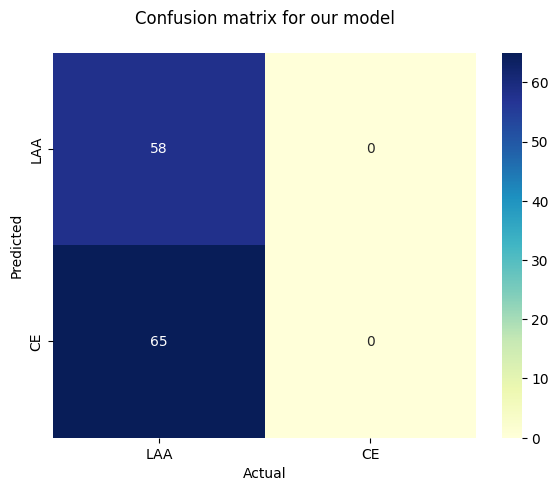

In [24]:
# Plot confusion matrices for benchmark and transfer learning models
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(15, 5))

preds = best_cnn.predict(x_test)
preds = (preds >= 0.5).astype(np.int32)

cm = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm, index=['LAA', 'CE'], columns=['LAA', 'CE'])
plt.subplot(121)
plt.title("Confusion matrix for our model\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")

## Submission for kaggle competition

In [25]:
test1=[]
for i in test_df['file_path']:
    x1=preprocess(i)
    test1.append(x1)
    print(i)
    
test1=np.array(test1)


../input/mayo-clinic-strip-ai/test/006388_0.tif
../input/mayo-clinic-strip-ai/test/008e5c_0.tif
../input/mayo-clinic-strip-ai/test/00c058_0.tif
../input/mayo-clinic-strip-ai/test/01adc5_0.tif


In [26]:
cnn_pred=model.predict(test1)
cnn_pred

array([[0.03277082],
       [0.02060708],
       [0.00661717],
       [0.02901626]], dtype=float32)

In [27]:
sub = pd.DataFrame(test_df["patient_id"].copy())
sub["CE"] = cnn_pred
sub["LAA"] = 1- sub["CE"]

sub = sub.groupby("patient_id").mean()
sub = sub[["CE", "LAA"]].round(6).reset_index()
sub

,patient_id,CE,LAA
0,006388,0.032771,0.967229
1,008e5c,0.020607,0.979393
2,00c058,0.006617,0.993383
3,01adc5,0.029016,0.970984


In [28]:
label_counts = train_df["label"].value_counts()
print(label_counts)

LAA    207
CE     200
Name: label, dtype: int64


In [29]:
sub["prediction"] = sub["CE"].apply(lambda x : "CE" if x>=0.5 else "LAA")
sub["actual"] = ["CE", "CE", "LAA","LAA"]
print(sub)

def weighted_log_loss(y_true, y_pred, weights, N):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    weights = np.array(weights)
    N = np.array(N) 

    # Compute log loss for each class
    log_loss_per_class = -np.sum(y_true / N[:, np.newaxis] * np.log(y_pred), axis=0)

    # Weighted log loss
    weighted_log_loss_value = np.sum(weights * log_loss_per_class) / np.sum(weights)
 
    return weighted_log_loss_value

y_true = np.array([[1, 0],
                [1, 0],
                [0, 1],
                [0, 1]])
    
N = [545,545,205,205]

y_pred = np.clip(sub.iloc[:, [1, 2]].values, 1e-15, 1 - 1e-15)

weights = np.array([1,1]) 

log_loss = weighted_log_loss(y_true, y_pred, weights, N)
print("log_loss:",log_loss)



  patient_id        CE       LAA prediction actual
0     006388  0.032771  0.967229        LAA     CE
1     008e5c  0.020607  0.979393        LAA     CE
2     00c058  0.006617  0.993383        LAA    LAA
3     01adc5  0.029016  0.970984        LAA    LAA
log_loss: 0.006785566360446084


In [30]:
#sub.to_csv("submission.csv", index = False)
#!head submission.csv

# Approach 2

## DenseNET